## Init

In [1]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import * 

import matplotlib.pyplot as plt
import roadrunner
import numpy as np
import pandas as pd

## Create an example Model

In [ ]:
runner_model = ModelBuilder('SimpleCascade')

A_species = ['A0', 'A1']
B_species = ['B0', 'B1']
C_species = ['C']

for specie in A_species:
    runner_model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,)))
    runner_model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))

for specie in B_species:
    runner_model.add_reaction(Reaction(michaelis_menten_stim, (specie+'p',), (specie,), extra_states=('A'+specie[1]+'p',)))
    runner_model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))
    
for specie in C_species:
    runner_model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,)))
    runner_model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))
    
# add stimulation reactions

print(runner_model.get_antimony_model())

model SimpleCascade

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: B0p -> B0; J4_Vmax*B0p*A0p/(J4_Km + B0p)
J5: B0 -> B0p; J5_Vmax*B0/(J5_Km + B0)
J6: B1p -> B1; J6_Vmax*B1p*A1p/(J6_Km + B1p)
J7: B1 -> B1p; J7_Vmax*B1/(J7_Km + B1)
J8: Cp -> C; J8_Vmax*Cp/(J8_Km + Cp)
J9: C -> Cp; J9_Vmax*C/(J9_Km + C)

# State variables in the system
A0p=0
A0=100
A1p=0
A1=100
B0p=0
B0=100
B1p=0
B1=100
Cp=0
C=100

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10
J2_Km=100
J2_Vmax=10
J3_Km=100
J3_Vmax=10
J4_Km=100
J4_Vmax=10
J5_Km=100
J5_Vmax=10
J6_Km=100
J6_Vmax=10
J7_Km=100
J7_Vmax=10
J8_Km=100
J8_Vmax=10
J9_Km=100
J9_Vmax=10

# Other variables in the system


end


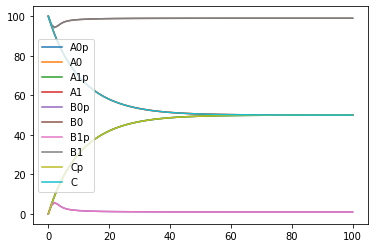

In [ ]:
runner = roadrunner.RoadRunner(runner_model.get_sbml_model())
res = runner.simulate(0, 100, 100)


states = runner_model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()

## Construst a more complex model based on rules

This script generates an arbitrarily large biochemical ODE system with the following limitations:
- A === B 
- Only 1 C specie
- No feedback regulations / crosstalk

In [4]:
R1 = Reaction(michaelis_menten, (specie+'p',), (specie,))
print(michaelis_menten.parameters_count)

2


In [ ]:
NA = 10
NB = 10
NC = 1
NR = 0

mean_range_species = (5, 500)
sd_range_species = (1, 100)

mean_range_params = (0.01, 1)
sd_range_params = (0.01, 1)

runner_model = ModelBuilder('SimpleCascade2')

# based on the `NA` parameter, create a number of species for A

A_species = [f'A{i}' for i in range(NA)]
B_species = [f'B{i}' for i in range(NB)]
C_species = ['C']

# convert a list of species to a tuple of species
B_species_tuple_phos = []
for b in B_species:
    b_specie_phos = b + 'p'
    B_species_tuple_phos.append(b_specie_phos)
    
B_species_tuple_phos = tuple(B_species_tuple_phos)


for specie in A_species:
    # generate a random set of parameters for reaction A -> Ap
    r_params = []
    for i in range(michaelis_menten.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params.append(rand)
        
    # add the reaction Ap -> A to the model    
    runner_model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,), 
                                parameters_values=tuple(r_params)))
    
    # generate a random initial value for A
    random_mean = np.random.randint(mean_range_species[0], mean_range_species[1])
    # generate a random set of parameters for reaction Ap -> A
    r_params_reverse = []
    for i in range(michaelis_menten.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params_reverse.append(rand)
        
    # add the reaction Ap -> A to the model    
    runner_model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',), 
                                reactant_values=random_mean, 
                                parameters_values=tuple(r_params_reverse)))

for specie in B_species:
    # generate a random set of parameters for reaction B -> Bp
    r_params = []
    for i in range(michaelis_menten_stim.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params.append(rand)
    
    # add the reaction Bp -> B to the model
    runner_model.add_reaction(Reaction(michaelis_menten_stim, (specie+'p',), (specie,), 
                                extra_states=('A'+specie[1]+'p',),
                                parameters_values=tuple(r_params)))
    
    # generate a random initial value for B
    random_mean = np.random.randint(mean_range_species[0], mean_range_species[1])
    
    # generate a random set of parameters for reaction B -> Bp
    r_params_reverse = []
    for i in range(michaelis_menten.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params_reverse.append(rand)
    
    # add the reaction B -> Bp to the model
    runner_model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',), 
                                reactant_values=random_mean,
                                parameters_values=tuple(r_params_reverse)))
    

# randomise the number of stimulators and inhibitors for len(B_species) 

stimulator_number = np.random.randint(0, len(B_species))
inhibitor_number = len(B_species) - stimulator_number   

rate_law_C = create_archtype_michaelis_menten(stimulators=stimulator_number,
                                              stimulator_weak=0, 
                                              allosteric_inhibitors=inhibitor_number, 
                                              competitive_inhibitors=0)    
    
for specie in C_species:
    runner_model.add_reaction(Reaction(rate_law_C, (specie+'p',), (specie,), extra_states=B_species_tuple_phos))
    runner_model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))
    
# add stimulation reactions

print(runner_model.get_antimony_model())

model SimpleCascade2

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: A5p -> A5; J10_Vmax*A5p/(J10_Km + A5p)
J11: A5 -> A5p; J11_Vmax*A5/(J11_Km + A5)
J12: A6p -> A6; J12_Vmax*A6p/(J12_Km + A6p)
J13: A6 -> A6p; J13_Vmax*A6/(J13_Km + A6)
J14: A7p -> A7; J14_Vmax*A7p/(J14_Km + A7p)
J15: A7 -> A7p; J15_Vmax*A7/(J15_Km + A7)
J16: A8p -> A8; J16_Vmax*A8p/(J16_Km + A8p)
J17: A8 -> A8p; J17_Vmax*A8/(J17_Km + A8)
J18: A9p -> A9; J18_Vmax*A9p/(J18_Km + A9p)
J19: A9 -> A9p; J19_Vmax*A9/(J19_Km + A9)
J20: B0p -> B0; J20_Vmax*B0p*A0p/(J20_Km + B0p)
J21: B0 -> B0p; J21_Vmax*B0/(J21_Km + B0)
J22: B1p -> B1; J22_Vmax*B1p*A1p/(J22_Km + B1p)
J23: B1 ->

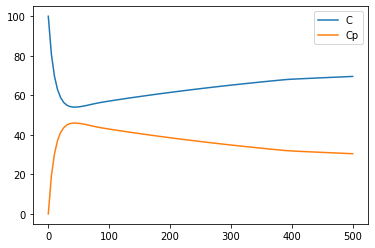

In [ ]:
runner = roadrunner.RoadRunner(runner_model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = runner_model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()

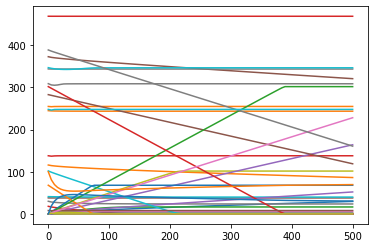

In [ ]:
runner = roadrunner.RoadRunner(runner_model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = runner_model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

# plt.legend()
plt.show()

## Complex model with feedback 
- to use the NR parameter and generate random crosstalks

### Construction

In [2]:
model_spec = ModelSpecification()
model_spec.generate_specifications(4, 5, 2, verbose=0)
G0 = model_spec.generate_network('TestNetwork', (5, 5000), (0.1, 10), (0.7, 1.3), random_seed=4)

Model States:  22
Model Parameters:  56
Model Reactions:  22


--- Antimony Model ---


model TestNetwork

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; (J3_Vmax+Cp*J3_Kw0)*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km*(1+B0p*J5_Kic0) + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+A3p*J17_Kw0)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_

### Simulation and visualisation

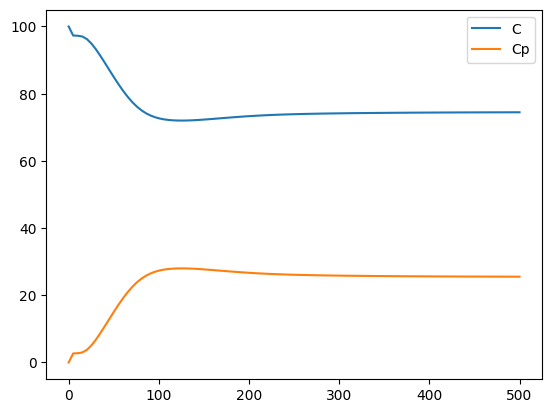

In [4]:
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, 500, 100)
states = G0.get_state_variables().keys()
visible_states = ['C', 'Cp']
for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)
plt.legend()
plt.show()

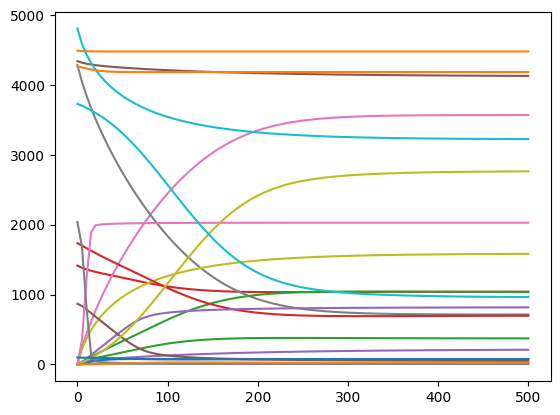

In [5]:
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)
# plt.legend()
plt.show()

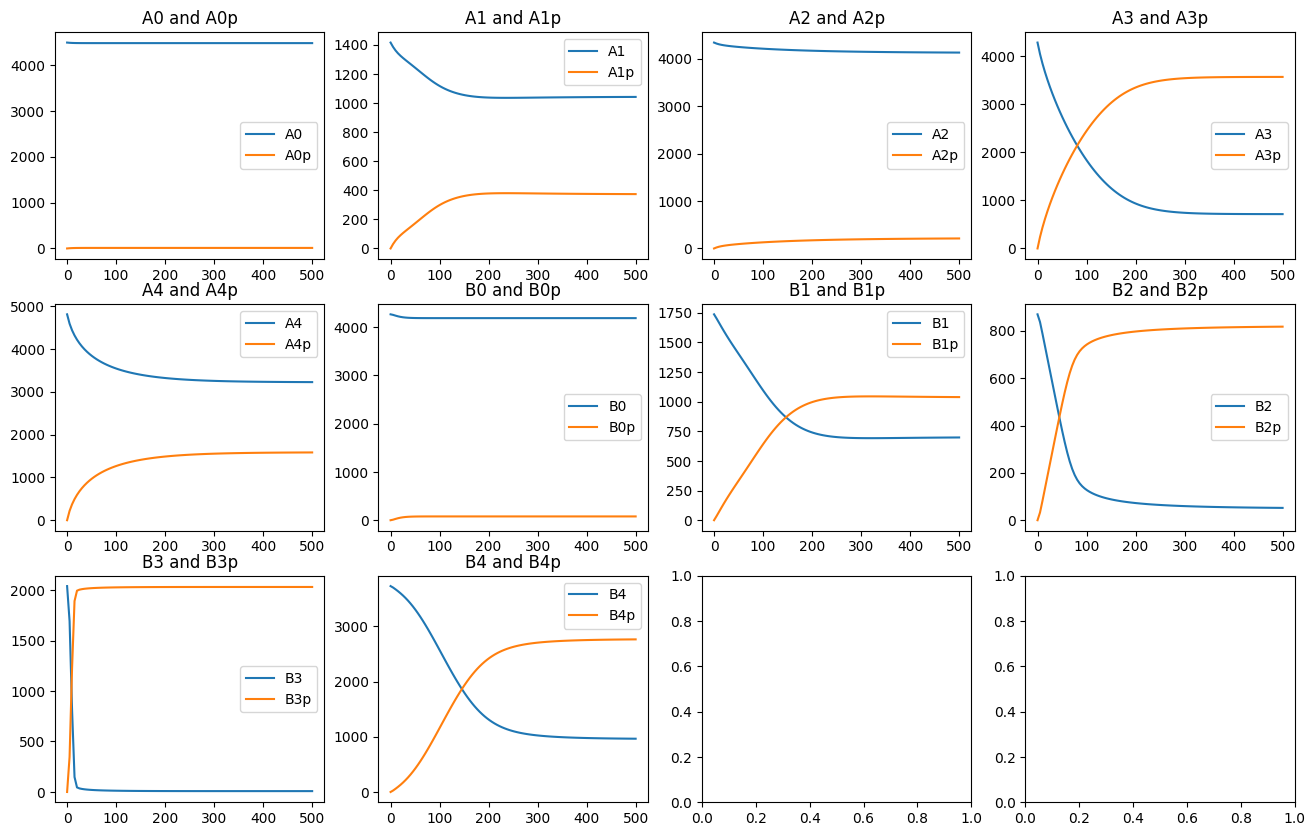

In [6]:
# make a multi-plot of the species, for each individual plot, show the species and the phosphorylated species

# use multiple subplots to show the species and the phosphorylated species for A and B
# ensure that the phosphorylated species are shown in the same plot as the original species

# create a subplot for each species, display 4 species per row
AandB = model_spec.A_species + model_spec.B_species
columns = 4
fig, axs = plt.subplots(len(AandB)//columns+1, columns, figsize=(4*columns, 4*len(AandB)//columns))
for i, specie in enumerate(AandB):
    row = i // columns
    col = i % columns
    # get the phosphorylated specie
    specie_phos = specie + 'p'
    # plot the specie
    axs[row, col].plot(res['time'], res[f'[{specie}]'], label=specie)
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos)
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()
plt.show()

### Generation of Synthetic Data 

By perturbing the model using sampling methods, a sample dataset is generated, where feature data is the initial values of A and the target being the value of C at a time threshold 

In [7]:
feature_df = generate_feature_data(model_spec, runner, 'uniform', {'min': 0.1, 'max': 10}, 1000, seed=50)
initial_values = get_model_initial_values(model_spec, runner)


In [8]:
target_df, time_course_data = generate_target_data(model_spec, runner, feature_df, initial_values)

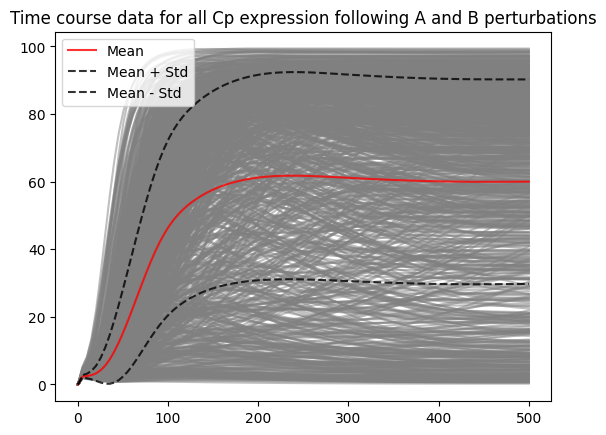

In [9]:
# plot the time course data
time_course_data = np.array(time_course_data)
time_course_data.shape

plt.title('Time course data for all Cp expression following A and B perturbations')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.legend()
plt.show()

In [10]:
feature_df_gaussian = generate_feature_data(model_spec, runner, 'gaussian', {'std': 50}, 1000, seed=4)
target_df_gaussian, time_course_data = generate_target_data(model_spec, runner, feature_df_gaussian, initial_values)

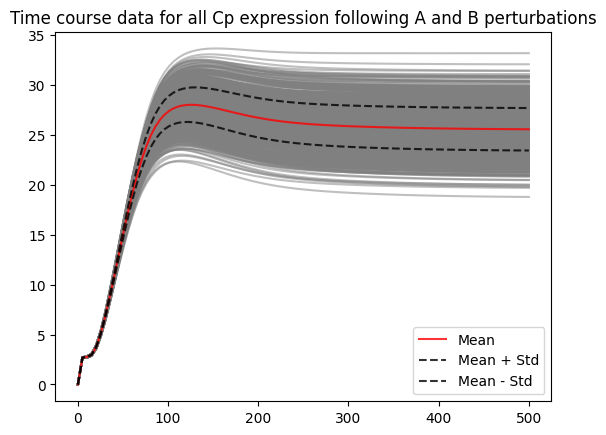

In [11]:
# plot the time course data
time_course_data = np.array(time_course_data)
time_course_data.shape

plt.title('Time course data for all Cp expression following A and B perturbations')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.legend()
plt.show()

In [12]:
feature_df_rsd = generate_feature_data(model_spec, runner, 'gaussian', {'rsd': 0.15}, 1000, seed=4)
target_df_rsd, time_course_data = generate_target_data(model_spec, runner, feature_df_rsd, initial_values)

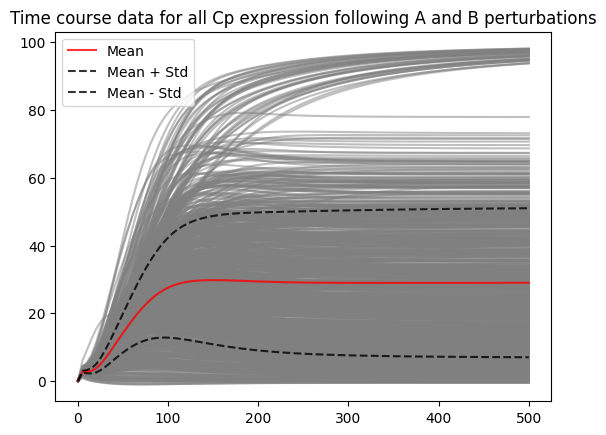

In [13]:
# plot the time course data
time_course_data = np.array(time_course_data)
time_course_data.shape

plt.title('Time course data for all Cp expression following A and B perturbations')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.legend()
plt.show()

### Generation of sub-optimal estimated models 

If the first generated model is treated as the ground truth model S0 (i.e. the true reality of cell signalling), sub-optimal models, S1, S2... are generated as estimates of the ground truth

#### Manual Trimming of an established network

In [14]:
'''
First create a ground truth model with a known set of parameters 
'''

model_spec = ModelSpecification()
model_spec.generate_specifications(4, 5, 2, verbose=0)
G0 = model_spec.generate_network('GroundTruthModel', (5, 5000), (0.1, 10), (0.7, 1.3), random_seed=4)

Model States:  22
Model Parameters:  56
Model Reactions:  22


--- Antimony Model ---


model GroundTruthModel

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; (J3_Vmax+Cp*J3_Kw0)*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km*(1+B0p*J5_Kic0) + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+A3p*J17_Kw0)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; 

In [15]:
print(model_spec)

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4')]
Regulation Types: ['up', 'down', 'up', 'up', 'up', 'up', 'up']
C Weak Stimulators: 2
C Strong Stimulators: 0
C Allosteric Inhibitors: 1
C Competitive Inhibitors: 2



In [16]:
'''
Then, create a new regulation list for the suboptimal model, S1 
'''

from copy import deepcopy

NR = 2

sub_regulations = model_spec.regulations[NR:]
sub_reg_types = model_spec.regulation_types[NR:]

print(sub_regulations)
print(sub_reg_types)

copy_model_spec = deepcopy(model_spec)

copy_model_spec.regulations = sub_regulations
copy_model_spec.regulation_types = sub_reg_types

print(copy_model_spec)

S0 = copy_model_spec.generate_network('SuboptimalModel', (5, 5000), (0.1, 10), (0.7, 1.3), random_seed=4, verbose=0)

G_params = G0.parameters.copy()
G_states = G0.states.copy()

# 
for p in G_params:
    if p in S0.parameters:
        S0.parameters[p] = G0.parameters[p]

for s in G_states:
    if s in S0.states:
        S0.states[s] = G0.states[s]
    
print(S0.get_antimony_model())


[('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4')]
['up', 'up', 'up', 'up', 'up']
A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4')]
Regulation Types: ['up', 'up', 'up', 'up', 'up']
C Weak Stimulators: 2
C Strong Stimulators: 0
C Allosteric Inhibitors: 1
C Competitive Inhibitors: 2

model SuboptimalModel

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + 

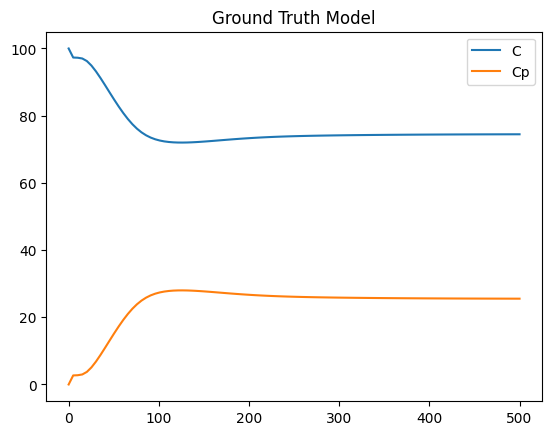

In [17]:
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = G0.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.title('Ground Truth Model')
plt.legend()
plt.show()

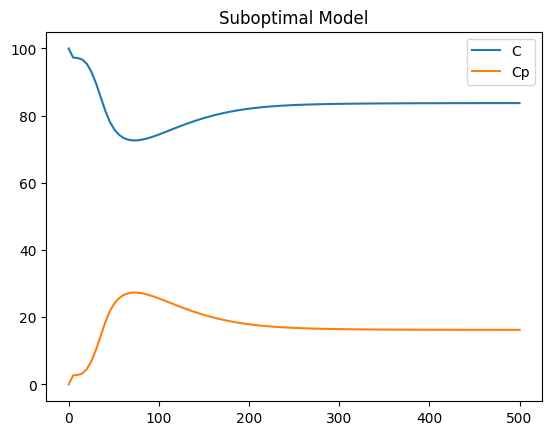

In [18]:
runner = roadrunner.RoadRunner(S0.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = S0.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.title('Suboptimal Model')
plt.legend()
plt.show()

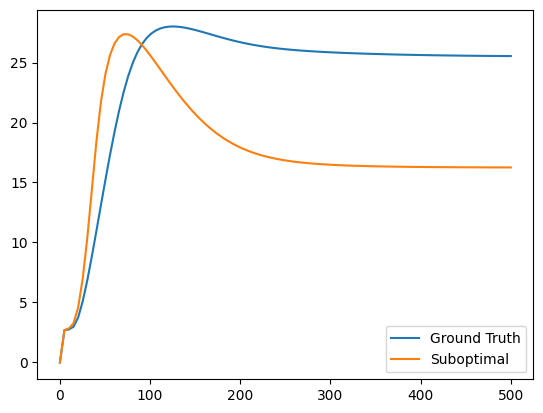

In [19]:
# make a sub-plot for the ground truth model and the suboptimal model, showing the Cp expression for C

runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, 500, 100)

runner_sub = roadrunner.RoadRunner(S0.get_sbml_model())
res_sub = runner_sub.simulate(0, 500, 100)

plt.plot(res['time'], res['[Cp]'], label='Ground Truth')
plt.plot(res_sub['time'], res_sub['[Cp]'], label='Suboptimal')
plt.legend()
plt.show()

runner = manual_reset(runner, initial_values)
runner_sub = manual_reset(runner_sub, initial_values)

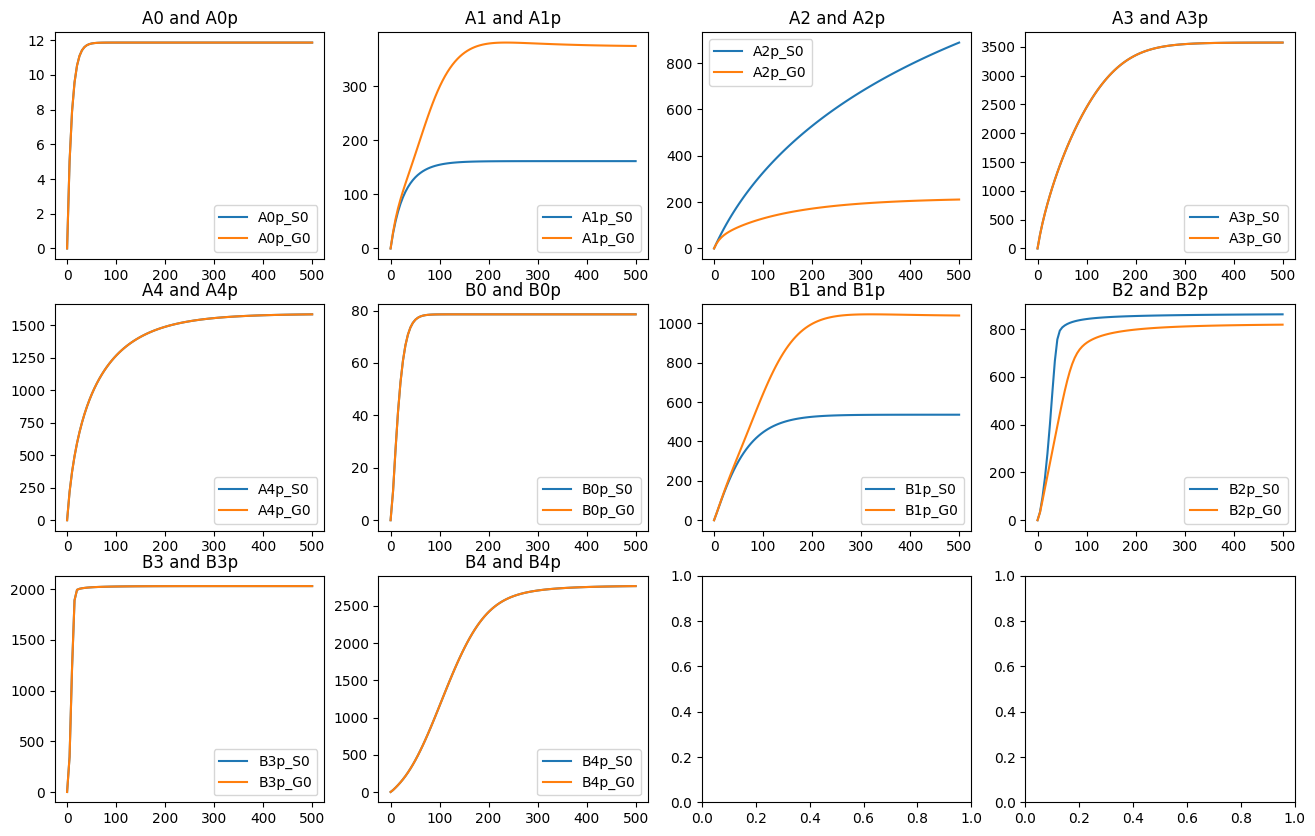

In [20]:
AandB = model_spec.A_species + model_spec.B_species
columns = 4
fig, axs = plt.subplots(len(AandB)//columns+1, columns, figsize=(4*columns, 4*len(AandB)//columns))
for i, specie in enumerate(AandB):
    row = i // columns
    col = i % columns
    # get the phosphorylated specie
    specie_phos = specie + 'p'
    # plot the specie
    # axs[row, col].plot(res_sub['time'], res_sub[f'[{specie}]'], label=specie+'_S0')
    # axs[row, col].plot(res['time'], res_sub[f'[{specie_phos}]'], label=specie+'_G0')
    axs[row, col].plot(res_sub['time'], res_sub[f'[{specie_phos}]'], label=specie_phos+'_S0')
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos+'_G0')
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()
plt.show()

#### Automatic random removal of feedback regulations in the network 

In [21]:
removal_rate = 0.1 # 10% of the regulations are removed

### Correlation of sub-optimal model with target data

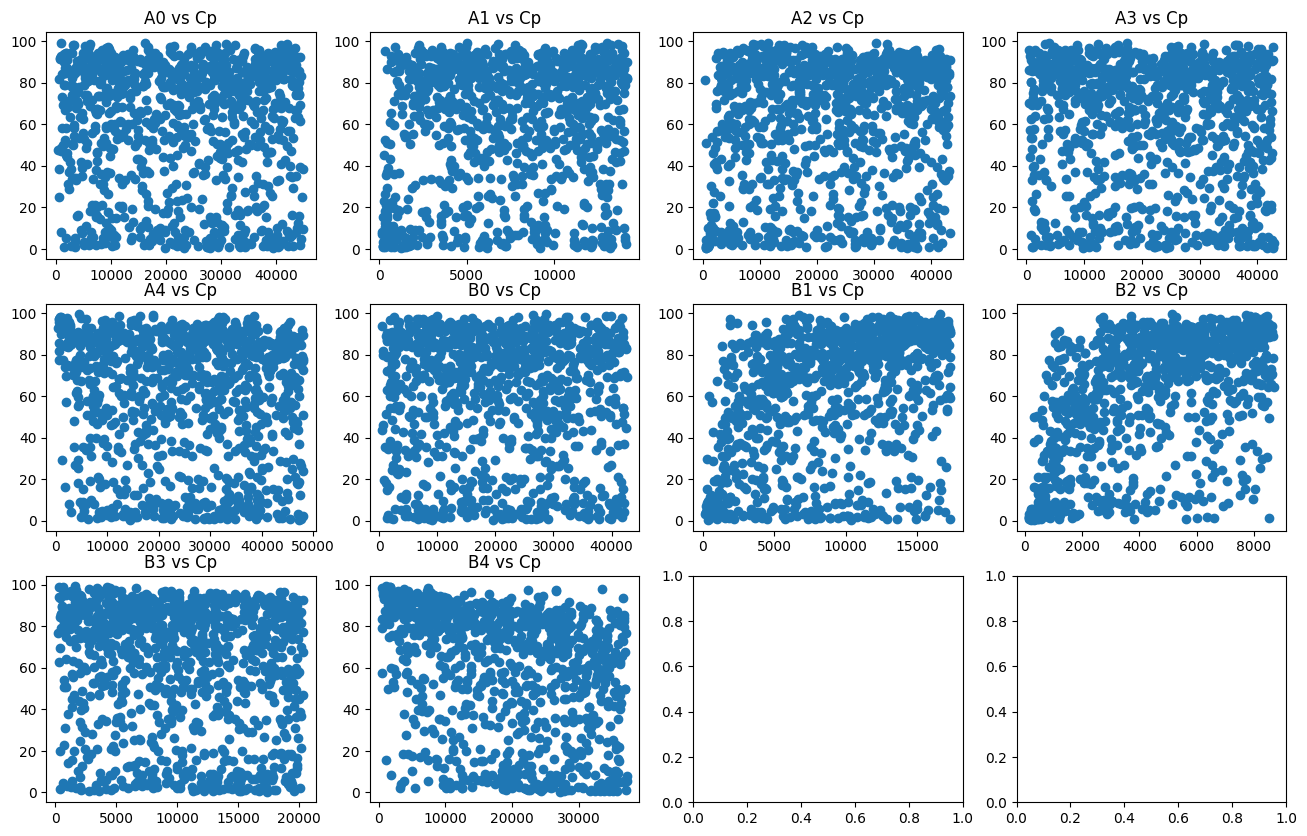

In [22]:
# investigate the correlation between feature data and target data first 

# plot scatter plots of the feature data and target data, use a subplot configuration 
target_df, _ = generate_target_data(model_spec, runner, feature_df, initial_values)

columns = 4
fig, axs = plt.subplots(len(feature_df.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(feature_df.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(feature_df[feature], target_df['Cp'])
    axs[row, col].set_title(f'{feature} vs Cp')
plt.show()




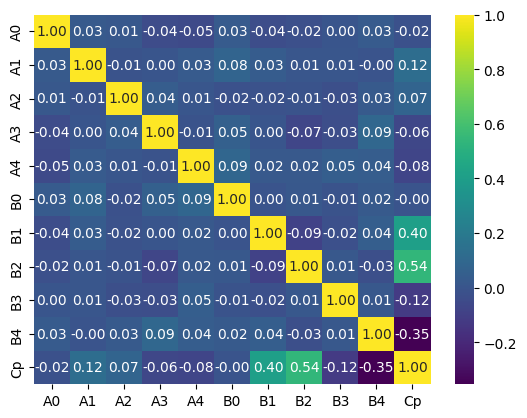

In [23]:
# plot the correlation matrix of between the feature data and the target data
import seaborn as sns
feature_target_df = feature_df.copy()
feature_target_df['Cp'] = target_df['Cp']
sns.heatmap(feature_target_df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.show()

In [24]:
# using the feature data, simulate the ground truth model and capture the time course data for all species
all_time_course_data = generate_model_timecourse_data(model_spec, runner, feature_df, initial_values)

In [25]:
# obtain the last time point for each phosphorylated species
all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
all_phos_species = [s+'p' for s in all_species]
all_time_course_data_phos = all_time_course_data[all_phos_species]


# Apply to every cell in the DataFrame
last_time_points = all_time_course_data_phos.applymap(lambda x: x[-1])

In [26]:
last_time_points

,A0p,A1p,A2p,A3p,A4p,B0p,B1p,B2p,B3p,B4p,Cp
0,12.469238,2329.383876,380.555869,11271.213494,2211.887658,95.557597,7055.775579,6702.761949,15553.419613,11255.228902,83.174734
1,12.403145,3118.832009,261.846932,12282.609977,2342.262112,93.796283,5471.148221,7680.579049,13818.376963,14297.838190,79.168040
2,12.473131,325.866923,725.102618,11872.137273,2309.069536,75.594055,3277.455047,563.120461,3831.325557,34038.885772,5.464958
3,12.544506,5258.703992,637.917321,11574.744957,2344.445801,93.899349,11862.955445,5667.807801,12287.957490,8059.147000,90.709940
4,12.512770,1370.360896,652.257560,11454.071510,2343.132663,95.471653,12348.403519,1148.909126,18697.887036,14173.464081,49.510238
...,...,...,...,...,...,...,...,...,...,...,...
995,12.545890,119.596707,742.382795,12042.529071,1947.018520,67.101469,725.788899,3186.109572,15791.744788,9866.364290,16.305166
996,12.332954,1276.400131,305.049876,11701.260820,2228.115972,83.633102,1469.765432,5770.363254,9018.989840,22823.020373,31.187694
997,12.511817,336.868741,475.530338,12237.423892,2280.724007,95.212850,419.951630,2830.297823,9088.282322,15424.383579,8.752560
998,12.356368,3759.588194,477.627388,12293.410919,2308.433381,93.899200,17091.098398,6121.514771,6703.534523,16909.219085,90.841161


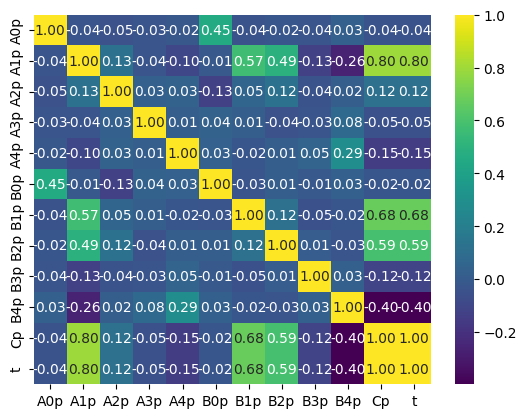

In [27]:
import seaborn as sns
# perform correlation analysis between the last time points and the target data
target_last_time_points_G0 = last_time_points.copy()
target_last_time_points_G0['t'] = target_df['Cp']
sns.heatmap(target_last_time_points_G0.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.show()


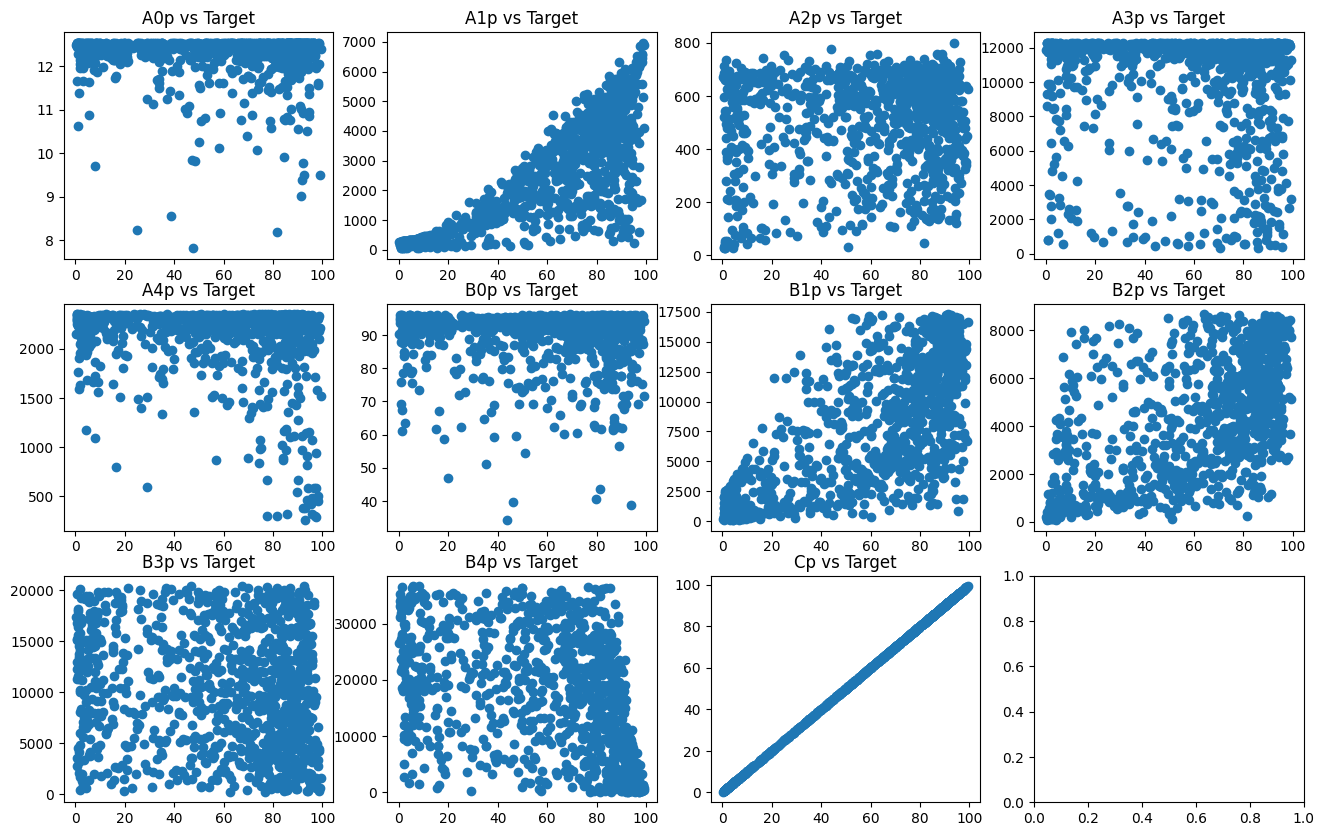

In [28]:
columns = 4
fig, axs = plt.subplots(len(last_time_points.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(last_time_points.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(target_df['Cp'], last_time_points[feature])
    axs[row, col].set_title(f'{feature} vs Target')
plt.show()

In [29]:
# using the feature data, simulate the suboptimal model and capture the time course data for all species
all_time_course_data_S0 = generate_model_timecourse_data(model_spec, runner_sub, feature_df, initial_values)

### Engineered Data - Last Point Method

In [30]:
# obtain the last time point for each phosphorylated species
all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
all_phos_species = [s+'p' for s in all_species]
all_time_course_data_phos = all_time_course_data_S0[all_phos_species]

# Apply to every cell in the DataFrame
last_time_points_S0 = all_time_course_data_phos.applymap(lambda x: x[-1])

In [31]:
# set the last time points as another feature dataset

engineered_feature_df = last_time_points_S0.copy()
combined_feature_df = pd.concat([feature_df, engineered_feature_df], axis=1)

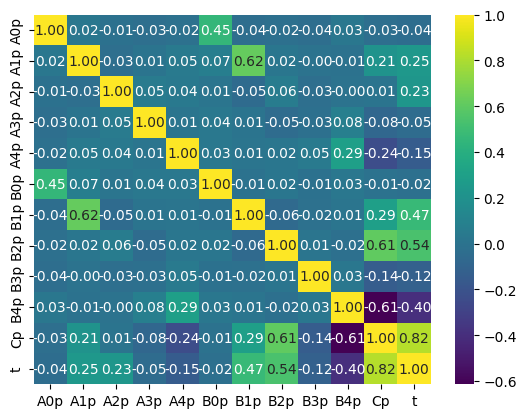

In [32]:
import seaborn as sns
# perform correlation analysis between the last time points and the target data
target_last_time_points_S0 = last_time_points_S0.copy()
target_last_time_points_S0['t'] = target_df['Cp']
sns.heatmap(target_last_time_points_S0.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.show()

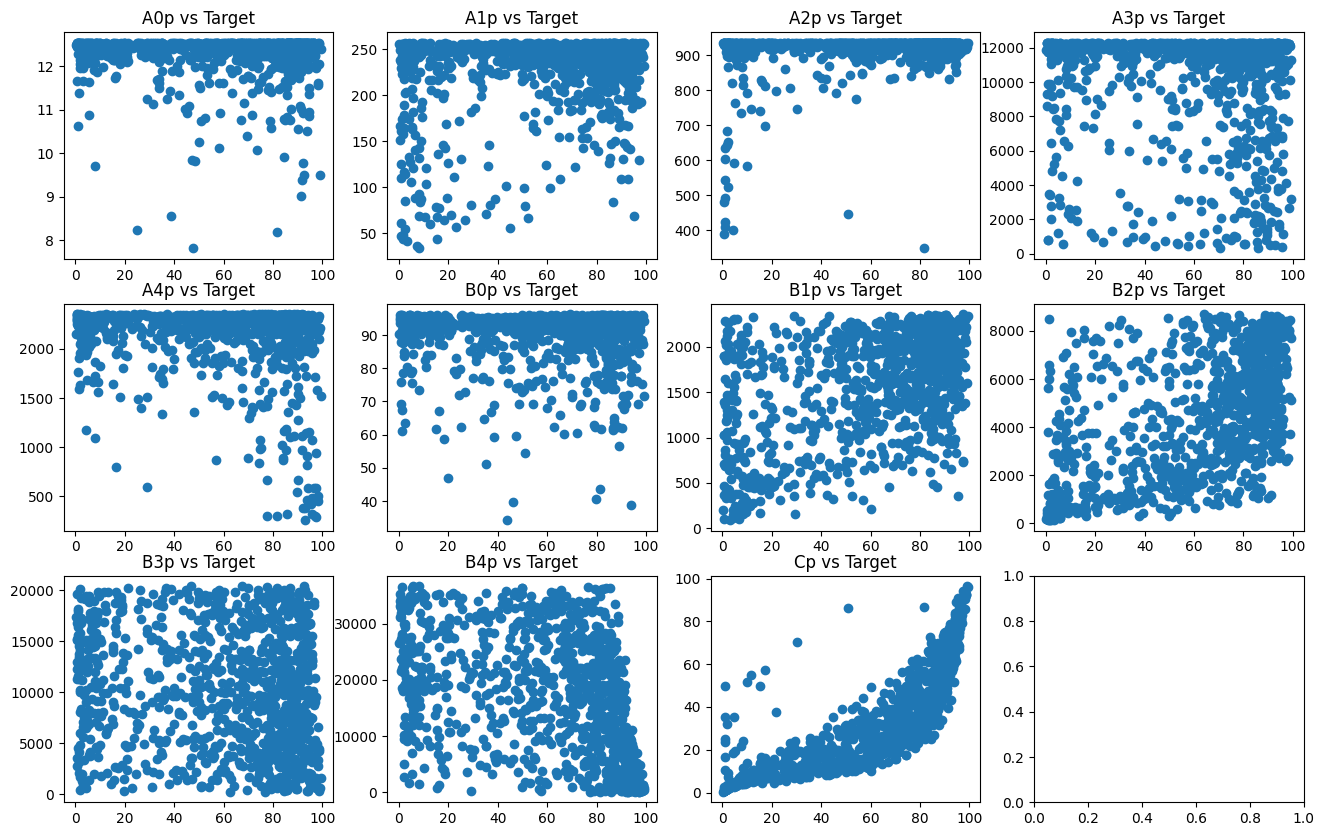

In [33]:
columns = 4
fig, axs = plt.subplots(len(last_time_points.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(last_time_points.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(target_df['Cp'], last_time_points_S0[feature])
    axs[row, col].set_title(f'{feature} vs Target')
plt.show()

### Using Machine Learning for Prediction

In [34]:
# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr

In [35]:
# use feature_df to predict target_df using a linear regression model

X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df['Cp'], test_size=0.2, random_state=4)

# create a linear regression model
lm = LinearRegression()

# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=4)

# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=4)

# create a support vector machine model
svr = SVR()

all_models = [lm, rf, gb, svr]

for model in all_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('--- Model:', model)
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))
    print('Pearson Correlation:', pearsonr(y_test, y_pred)[0], pearsonr(y_test, y_pred)[1])


--- Model: LinearRegression()
Mean Squared Error: 314.9296606272954
R2 Score: 0.6148516959488408
Pearson Correlation: 0.7859195616166648 3.294550074695297e-43
--- Model: RandomForestRegressor(random_state=4)
Mean Squared Error: 93.97278056213872
R2 Score: 0.8850744734923118
Pearson Correlation: 0.9434239845086285 7.192436864968086e-97
--- Model: GradientBoostingRegressor(random_state=4)
Mean Squared Error: 65.52090979095038
R2 Score: 0.9198701473986018
Pearson Correlation: 0.9599169745524201 2.4846156136466644e-111
--- Model: SVR()
Mean Squared Error: 689.4274623497963
R2 Score: 0.15685357371097852
Pearson Correlation: 0.6302656735956965 1.530973261073059e-23


In [36]:
# use engineered_feature_df to predict target_df using a linear regression model

X_train, X_test, y_train, y_test = train_test_split(engineered_feature_df, target_df['Cp'], test_size=0.2, random_state=4)

# create a linear regression model
lm = LinearRegression()

# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=4)

# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=4)

# create a support vector machine model
svr = SVR()

all_models = [lm, rf, gb, svr]

for model in all_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('--- Model:', model)
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))
    print('Pearson Correlation:', pearsonr(y_test, y_pred)[0], pearsonr(y_test, y_pred)[1])

--- Model: LinearRegression()
Mean Squared Error: 177.93706007789035
R2 Score: 0.7823890046420451
Pearson Correlation: 0.8889756814960856 4.4299483497203047e-69
--- Model: RandomForestRegressor(random_state=4)
Mean Squared Error: 62.01755160362673
R2 Score: 0.9241546357559188
Pearson Correlation: 0.961460641950285 5.49380936795817e-113
--- Model: GradientBoostingRegressor(random_state=4)
Mean Squared Error: 52.864429269372785
R2 Score: 0.9353485942315631
Pearson Correlation: 0.9672648317064964 7.018230041162446e-120
--- Model: SVR()
Mean Squared Error: 635.5095706970142
R2 Score: 0.22279332827940967
Pearson Correlation: 0.5645463261515908 3.1372030329408048e-18


In [37]:
# use combined_feature_df to predict target_df using a linear regression model

X_train, X_test, y_train, y_test = train_test_split(combined_feature_df, target_df['Cp'], test_size=0.2, random_state=4)

# create a linear regression model
lm = LinearRegression()

# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=4)

# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=4)

# create a support vector machine model
svr = SVR()

all_models = [lm, rf, gb, svr]

for model in all_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('--- Model:', model)
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))
    print('Pearson Correlation:', pearsonr(y_test, y_pred)[0], pearsonr(y_test, y_pred)[1])

--- Model: LinearRegression()
Mean Squared Error: 123.50813929934813
R2 Score: 0.848953730515863
Pearson Correlation: 0.9244520704848718 7.537771671393901e-85
--- Model: RandomForestRegressor(random_state=4)
Mean Squared Error: 60.180099119187034
R2 Score: 0.9264017778852023
Pearson Correlation: 0.9626294900474726 2.7592772815282484e-114
--- Model: GradientBoostingRegressor(random_state=4)
Mean Squared Error: 49.909448761431975
R2 Score: 0.9389624352679098
Pearson Correlation: 0.9691708924095368 2.0310015548950473e-122
--- Model: SVR()
Mean Squared Error: 655.1669035697818
R2 Score: 0.19875307623380944
Pearson Correlation: 0.6176304263813978 2.0126957852879003e-22


In [38]:
# create a function to evaluate the model performance 

def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # print('--- Model:', model)
    # print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    # print('R2 Score:', r2_score(y_test, y_pred))
    # print('Pearson Correlation:', pearsonr(y_test, y_pred)[0], pearsonr(y_test, y_pred)[1])
    # return model
    
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }


# create a linear regression model
lm = LinearRegression()

# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=4)

# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=4)

# create a support vector machine model
svr = SVR()

# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=4)

all_models = [lm, rf, gb, svr, nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = [feature_df, engineered_feature_df, combined_feature_df]
all_features_desc = ['Feature Data', 'Engineered Feature Data', 'Combined Feature Data']
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

metric_data = []
parallelise = True
if not parallelise:          
    for (feature_data, feature_data_name) in zipped_feature_data:
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df
    


,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,Feature Data,288.005727,0.654645,0.811839,3.755530e-48
1,Linear Regression,Feature Data,305.293290,0.698486,0.837458,7.451475e-54
2,Linear Regression,Feature Data,302.395508,0.697379,0.838834,3.453457e-54
3,Linear Regression,Feature Data,264.961664,0.708473,0.843121,2.998665e-55
4,Linear Regression,Feature Data,293.048549,0.673967,0.824854,6.220746e-51
...,...,...,...,...,...,...
145,Neural Network,Combined Feature Data,70973.943533,-81.407363,0.174888,1.325290e-02
146,Neural Network,Combined Feature Data,57196.892853,-54.361406,0.201697,4.182646e-03
147,Neural Network,Combined Feature Data,87790.571205,-84.777138,0.049249,4.885960e-01
148,Neural Network,Combined Feature Data,61724.643065,-68.133866,0.097743,1.685360e-01


### Visualise All Machine Learning Metrics

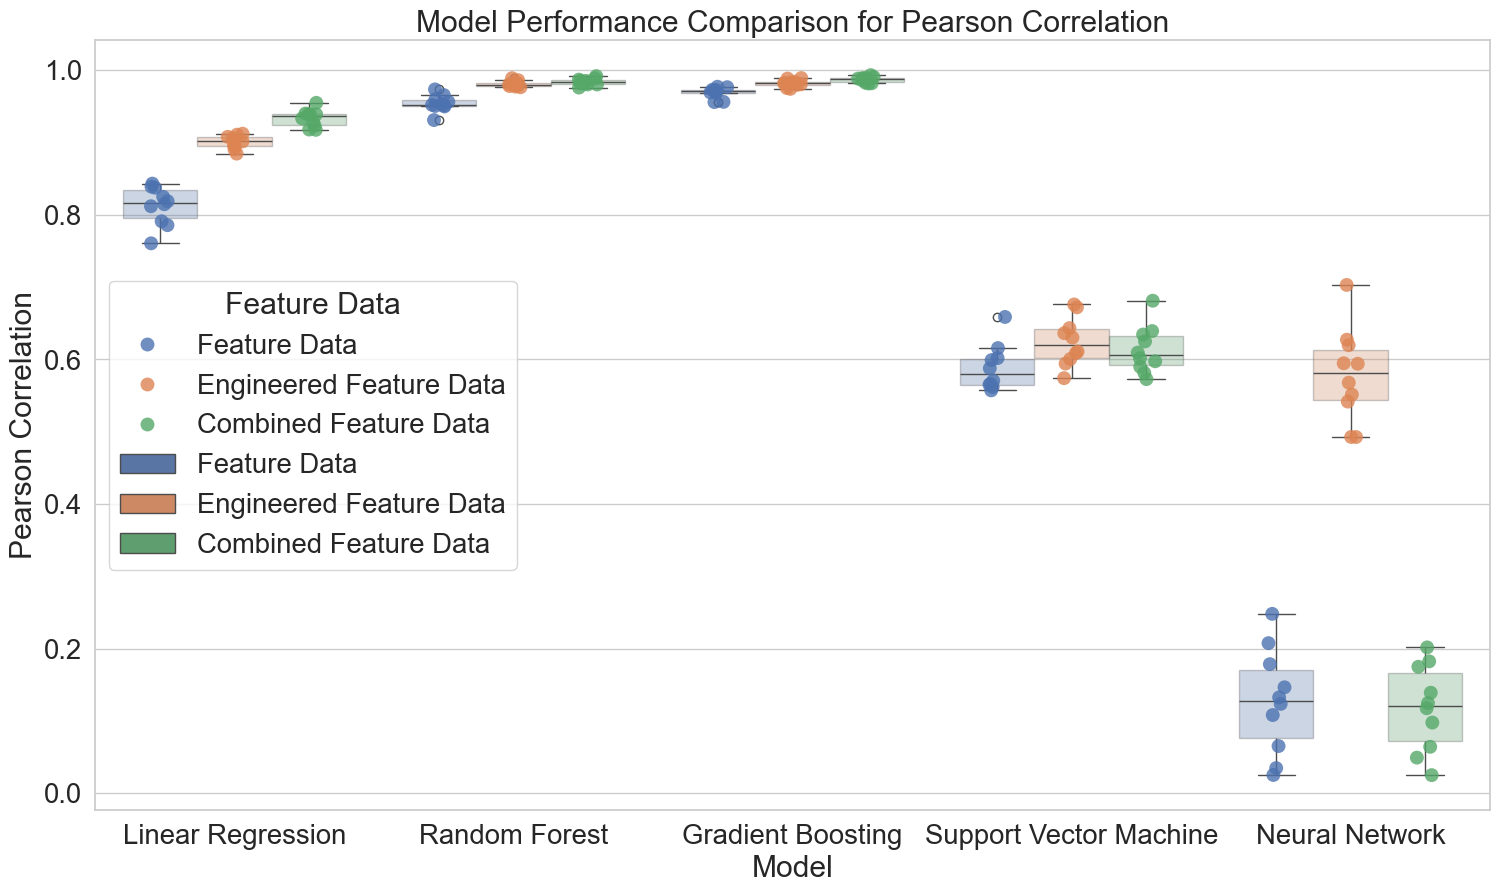

In [39]:
# import sns and matplotlib to visualise the data
import seaborn as sns
import matplotlib.pyplot as plt

# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.show()


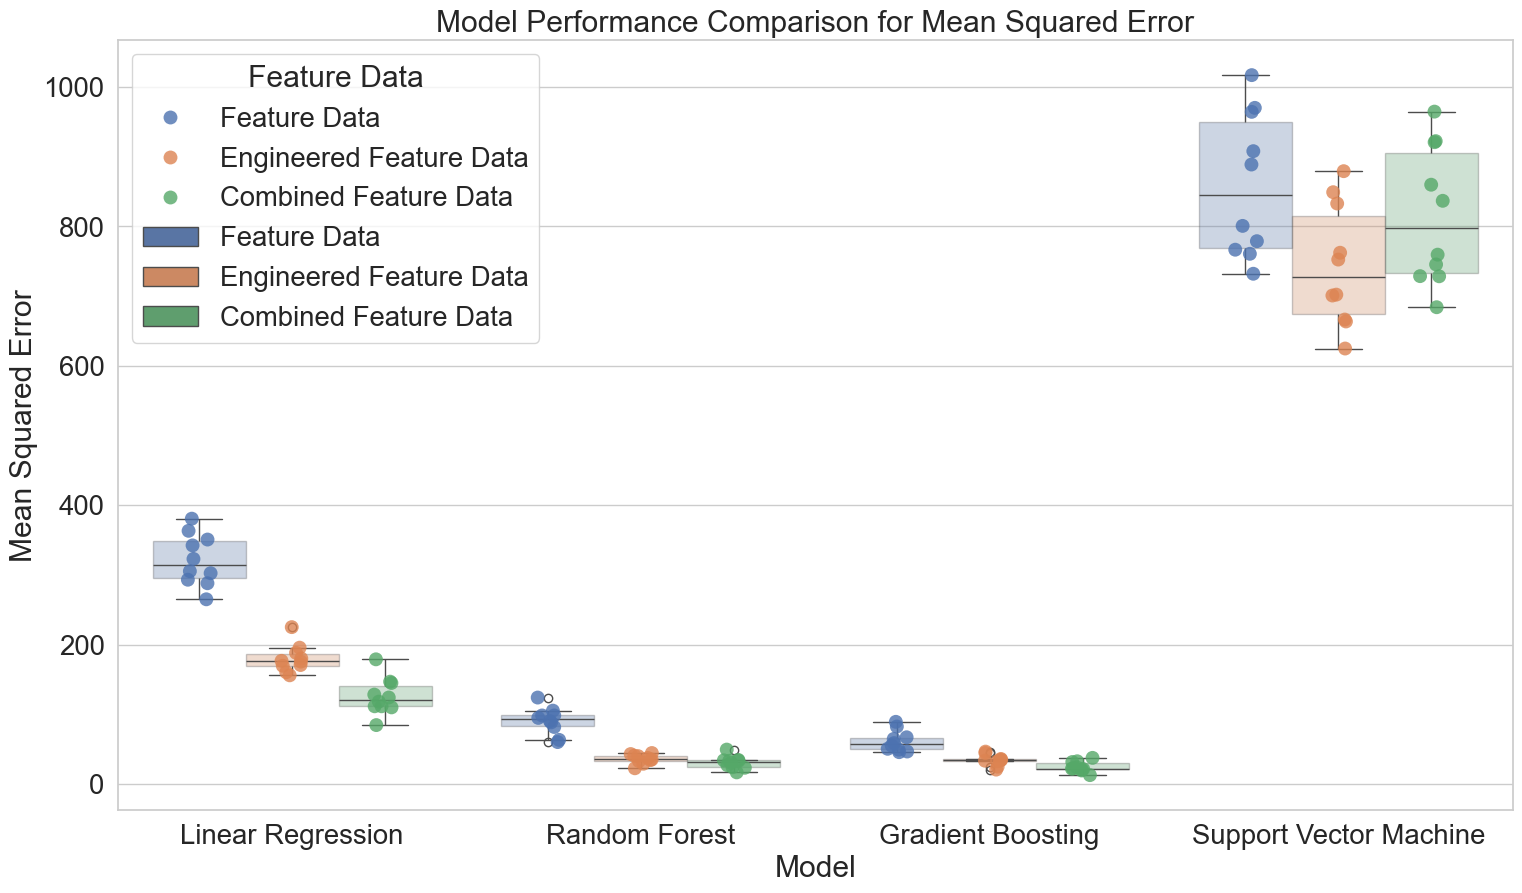

In [41]:
# import sns and matplotlib to visualise the data
import seaborn as sns
import matplotlib.pyplot as plt


# remove neural network from metric_df 
rm_metric_df = metric_df[metric_df['Model'] != 'Neural Network']

# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=rm_metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=rm_metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.show()

## Testing

In [ ]:
import pickle 

# load a model from a file
path = 'models\examples\InterestingSmallModel.pkl'

with open(path, 'rb') as f:
    runner_model = pickle.load(f)
    
print(runner_model.get_antimony_model())

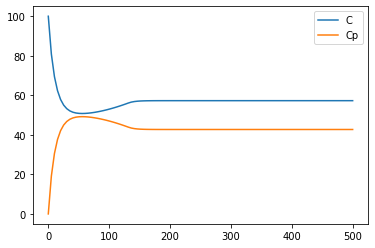

In [ ]:
runner = roadrunner.RoadRunner(runner_model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = runner_model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()